In [2]:
import sys
sys.path.append("../")
import re
from os.path import join
from IPython.display import display
import gc

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rc('text', usetex=True)

import matplotlib.pyplot as plt
import joblib
import numpy as np
import pandas as pd
import torch
import joblib
import faiss
from tqdm.notebook import tqdm
from mkdir_p import mkdir_p
import cvxpy

from lolip.models.torch_utils.archs import *
from lolip.variables import auto_var
from params import *
from utils import params_to_dataframe

fontsize=24

(CVXPY) Jan 12 04:42:48 AM: Encountered unexpected exception importing solver GUROBI:
ImportError('libgurobi100.so: cannot open shared object file: No such file or directory')
(CVXPY) Jan 12 04:42:48 AM: Encountered unexpected exception importing solver GUROBI:
ImportError('libgurobi100.so: cannot open shared object file: No such file or directory')


# Precalculate nearest neighbors for each dataset

In [ ]:
def calc_nn(ds_name, random_seed=0):
    auto_var.set_variable_value("random_seed", random_seed)
    trnX, trny, tstX, tsty, rest = auto_var.get_var_with_argument("dataset", ds_name)
    miss_trn_X, miss_tst_X = rest[0], rest[1]
    
    if "aug10-imgnet100" == ds_name[:15]:
        print("in")
        from torchvision import transforms
        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
        def np_normalize(X):
            X = X.transpose(0, 3, 1, 2)
            return normalize(torch.from_numpy(X)).numpy().transpose(0, 2, 3, 1)
        trnX = np_normalize(trnX).astype(np.float32)
        tstX = np_normalize(tstX).astype(np.float32)
        miss_trn_X = np_normalize(rest[0]).astype(np.float32)
        miss_tst_X = np_normalize(rest[1]).astype(np.float32)
    elif "pathmnist" in ds_name or "dermamnist" in ds_name:
        print("in")
        from torchvision import transforms
        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
        def np_normalize(X):
            X = X.transpose(0, 3, 1, 2)
            return normalize(torch.from_numpy(X)).numpy().transpose(0, 2, 3, 1)
        trnX = np_normalize(trnX).astype(np.float32)
        tstX = np_normalize(tstX).astype(np.float32)
        miss_trn_X = np_normalize(rest[0]).astype(np.float32)
        miss_tst_X = np_normalize(rest[1]).astype(np.float32)
        
    trnX = trnX.reshape(len(trnX), -1)
    gc.collect()
    #print("L1")
    #index = faiss.IndexFlat(trnX.shape[1], faiss.METRIC_L1)
    #index.add(trnX.reshape(len(trnX), -1))
    #miss_trn_knn_y_1_dist, miss_trn_knn_y_1_ind = index.search(miss_trn_X.reshape(len(miss_trn_X), -1), k=1)
    #miss_tst_knn_y_1_dist, miss_tst_knn_y_1_ind = index.search(miss_tst_X.reshape(len(miss_tst_X), -1), k=1)
    #del index
    print("L2")
    index = faiss.IndexFlatL2(trnX.shape[1])
    index.add(trnX.reshape(len(trnX), -1))
    miss_trn_knn_y_2_dist, miss_trn_knn_y_2_ind = index.search(miss_trn_X.reshape(len(miss_trn_X), -1), k=1)
    miss_tst_knn_y_2_dist, miss_tst_knn_y_2_ind = index.search(miss_tst_X.reshape(len(miss_tst_X), -1), k=1)
    miss_trn_knn_y_2_dist = np.sqrt(miss_trn_knn_y_2_dist)
    miss_tst_knn_y_2_dist = np.sqrt(miss_tst_knn_y_2_dist)
    del index
    #print("Linf")
    #index = faiss.IndexFlat(trnX.shape[1], faiss.METRIC_Linf)
    #index.add(trnX.reshape(len(trnX), -1))
    #miss_trn_knn_y_inf_dist, miss_trn_knn_y_inf_ind = index.search(miss_trn_X.reshape(len(miss_trn_X), -1), k=1)
    #miss_tst_knn_y_inf_dist, miss_tst_knn_y_inf_ind = index.search(miss_tst_X.reshape(len(miss_tst_X), -1), k=1)
    #del index
    joblib.dump({
        #'miss_trn_knn_y_inf_dist': miss_trn_knn_y_inf_dist,
        #'miss_tst_knn_y_inf_dist': miss_tst_knn_y_inf_dist,
        'miss_trn_knn_y_2_dist': miss_trn_knn_y_2_dist,
        'miss_tst_knn_y_2_dist': miss_tst_knn_y_2_dist,
        #'miss_trn_knn_y_1_dist': miss_trn_knn_y_1_dist,
        #'miss_tst_knn_y_1_dist': miss_tst_knn_y_1_dist,

        #'miss_trn_knn_y_inf_ind': miss_trn_knn_y_inf_ind,
        #'miss_tst_knn_y_inf_ind': miss_tst_knn_y_inf_ind,
        'miss_trn_knn_y_2_ind': miss_trn_knn_y_2_ind,
        'miss_tst_knn_y_2_ind': miss_tst_knn_y_2_ind,
        #'miss_trn_knn_y_1_ind': miss_trn_knn_y_1_ind,
        #'miss_tst_knn_y_1_ind': miss_tst_knn_y_1_ind,

        #'miss_trn_knn_y_inf': trny[miss_trn_knn_y_inf_ind],
        #'miss_tst_knn_y_inf': trny[miss_tst_knn_y_inf_ind],
        'miss_trn_knn_y_2': trny[miss_trn_knn_y_2_ind],
        'miss_tst_knn_y_2': trny[miss_tst_knn_y_2_ind],
        #'miss_trn_knn_y_1': trny[miss_trn_knn_y_1_ind],
        #'miss_tst_knn_y_1': trny[miss_tst_knn_y_1_ind],
    }, f"./out_of_sample/{ds_name}.pkl")
    print("done")
    
ds_names = [f"mnistwo{i}" for i in range(10)]
ds_names = [f"cifar10wo{i}" for i in range(10)]
ds_names = [f"cifar100coarsewo{i}" for i in range(1, 5)]
ds_names = ['cifar100wosp1',]
ds_names = [f'calcedrepr-mnistwo{i}-cwl2-128-mnistwo{i}-70-1.0-0.01-ce-vtor2-CNN002-0.9-2-sgd-0-0.0.pkl' for i in range(10)]
ds_names = [f'calcedrepr-cifar10wo{i}-cwl2-64-cifar10wo{i}-70-1.0-0.01-ce-vtor2-WRN_40_10-0.0-2-adam-0-0.0.pkl' for i in [0, 4, 9]]
ds_names = [f'calcedrepr-cifar10wo{i}-cwl2-64-cifar10wo{i}-70-4.0-0.01-trades6ce-vtor2-WRN_40_10-0.0-2-adam-0-0.0.pkl' for i in [0, 4, 9]]
ds_names = [f"cifar100coarsewo{i}" for i in range(5, 10)]
#ds_names = [f'calcedrepr-cifar100coarsewo{i}-cwl2-64-cifar100coarsewo{i}-70-1.0-0.01-ce-vtor2-WRN_40_10-0.0-2-adam-0-0.0.pkl' for i in [0, 4, 9]]
#ds_names = [f'crepr-WRN_40_10-cifar100coarsewo{i}-pgd-64-cifar100coarsewo{i}-70-1.0-0.01-ce-vtor2-WRN_40_10-0.0-2-adam-0-0.0-ep0070.pt' for i in range(10)]
#ds_names = [
#    'crepr-WRN_40_10-cifar100coarsewo0-pgd-64-cifar100coarsewo0-70-1.0-0.01-ce-vtor2-WRN_40_10-0.0-2-adam-0-0.0-ep0070.pt',
#    'calcedrepr-cifar100coarsewo0-cwl2-64-cifar100coarsewo0-70-1.0-0.01-ce-vtor2-WRN_40_10-0.0-2-adam-0-0.0.pkl',
#    'crepr-WRN_40_10-cifar100wosp1-pgd-64-cifar100wosp1-70-1.0-0.01-ce-vtor2-WRN_40_10-0.0-2-adam-0-0.0-ep0070.pt',
#    'calcedrepr-cifar100wosp1-cwl2-64-cifar100wosp1-70-1.0-0.01-ce-vtor2-WRN_40_10-0.0-2-adam-0-0.0.pkl',
#]
#
#ds_names = [f"fashionwo{i}" for i in [0]]
ds_names = [f"calcedrepr-aug10-imgnet100wo{i}-cwl2-128-aug10-imgnet100wo{i}-70-1.0-0.01-ce-vtor2-ResNet50Norm01-0.0-2-adam-0-0.0.pkl" for i in range(3, 10)]
ds_names = [f"aug10-imgnet100wo{i}" for i in range(5, 10)]
#ds_names = [f'calcedrepr-cifar100coarsewo{i}-cwl2-64-cifar100coarsewo{i}-70-1.0-0.01-ce-vtor2-WRN_40_10-0.0-2-adam-0-0.0.pkl' for i in [1, 2, 3, 5, 6, 7, 8]]
#ds_names = [f'calcedrepr-cifar100coarsewo{i}-cwl2-64-cifar100coarsewo{i}-70-1.0-0.01-ce-vtor2-WRN_40_10-0.0-2-adam-0-0.0.pkl' for i in [0, 4, 9]]

ds_names = [f"pathmnistwo{i}" for i in [0, 1, 2]]
#ds_names = [f"dermamnistwo{i}" for i in [0]]

for name in ds_names:
    print(name)
    calc_nn(name)

In [4]:
def calc_tstX_nn(ds_name):
    auto_var.set_variable_value("random_seed", 0)
    trnX, trny, tstX, tsty, rest = auto_var.get_var_with_argument("dataset", ds_name)
    
    if "aug10-imgnet100" == ds_name[:15]:
        print("in")
        from torchvision import transforms
        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
        def np_normalize(X):
            X = X.transpose(0, 3, 1, 2)
            return normalize(torch.from_numpy(X)).numpy().transpose(0, 2, 3, 1)
        trnX = np_normalize(trnX).astype(np.float32)
        tstX = np_normalize(tstX).astype(np.float32)
        
    tstX = tstX.reshape(len(tstX), -1)
    trnX = trnX.reshape(len(trnX), -1)
    gc.collect()
    print(trny.shape, trnX.shape)

    print("L2")
    index = faiss.IndexFlatL2(trnX.shape[1])
    index.add(trnX.reshape(len(trnX), -1))
    l2_dist, l2_ind = index.search(tstX, k=5)
    l2_dist = np.sqrt(l2_dist)
    del index
    #print("Linf")
    #index = faiss.IndexFlat(trnX.shape[1], faiss.METRIC_Linf)
    #index.add(trnX.reshape(len(trnX), -1))
    #linf_dist, linf_ind = index.search(tstX, k=5)
    #del index
    joblib.dump({
        #'linf_dist': linf_dist,
        'l2_dist': l2_dist,

        #'linf_ind': linf_ind,
        'l2_ind': l2_ind,

        #'knn_y_inf': trny[linf_ind],
        'knn_y_2': trny[l2_ind],
    }, f"./out_of_sample/tst_k5/{ds_name}.pkl")

#ds_names = [f'calcedrepr-mnistwo{i}-cwl2-128-mnistwo{i}-70-1.0-0.01-ce-vtor2-CNN002-0.9-2-sgd-0-0.0.pkl' for i in range(10)]
#ds_names += [f'calcedrepr-cifar10wo{i}-cwl2-64-cifar10wo{i}-70-1.0-0.01-ce-vtor2-WRN_40_10-0.0-2-adam-0-0.0.pkl' for i in [0, 4, 9]]
#ds_names += [f'calcedrepr-cifar100coarsewo{i}-cwl2-64-cifar100coarsewo{i}-70-1.0-0.01-ce-vtor2-WRN_40_10-0.0-2-adam-0-0.0.pkl' for i in [0, 4, 9]]
#ds_names += [f"calcedrepr-aug10-imgnet100wo{i}-cwl2-128-aug10-imgnet100wo{i}-70-1.0-0.01-ce-vtor2-ResNet50Norm01-0.0-2-adam-0-0.0.pkl" for i in range(3)]

ds_names = [f"mnistwo{i}" for i in range(10)]
#ds_names += [f"cifar10wo{i}" for i in range(10)]
ds_names += [f"cifar100coarsewo{i}" for i in range(10)]
#ds_names += [f"aug10-imgnet100wo{i}" for i in range(5)]

for name in ds_names:
    print(name)
    calc_tstX_nn(name)

mnistwo0
(54077,) (54077, 784)
L2
mnistwo1
(53258,) (53258, 784)
L2
mnistwo2
(54042,) (54042, 784)
L2
mnistwo3
(53869,) (53869, 784)
L2
mnistwo4
(54158,) (54158, 784)
L2
mnistwo5
(54579,) (54579, 784)
L2
mnistwo6
(54082,) (54082, 784)
L2
mnistwo7
(53735,) (53735, 784)
L2
mnistwo8
(54149,) (54149, 784)
L2
mnistwo9
(54051,) (54051, 784)
L2
cifar100coarsewo0
(47500,) (47500, 3072)
L2
cifar100coarsewo1
(47500,) (47500, 3072)
L2
cifar100coarsewo2
(47500,) (47500, 3072)
L2
cifar100coarsewo3
(47500,) (47500, 3072)
L2
cifar100coarsewo4
(47500,) (47500, 3072)
L2
cifar100coarsewo5
(47500,) (47500, 3072)
L2
cifar100coarsewo6
(47500,) (47500, 3072)
L2
cifar100coarsewo7
(47500,) (47500, 3072)
L2
cifar100coarsewo8
(47500,) (47500, 3072)
L2
cifar100coarsewo9
(47500,) (47500, 3072)
L2


In [ ]:
def calc_ood_nn(ds_name):
    auto_var.set_variable_value("random_seed", 0)
    trnX, trny, tstX, tsty, rest = auto_var.get_var_with_argument("dataset", ds_name)
    oodX = np.concatenate((rest[0], rest[1]), axis=0)
    oodX = oodX.reshape(len(oodX), -1)
    trnX = trnX.reshape(len(trnX), -1)
    gc.collect()

    print("L2")
    index = faiss.IndexFlatL2(trnX.shape[1])
    index.add(trnX.reshape(len(trnX), -1))
    l2_dist, l2_ind = index.search(oodX, k=5)
    l2_dist = np.sqrt(l2_dist)
    del index
    print("Linf")
    index = faiss.IndexFlat(trnX.shape[1], faiss.METRIC_Linf)
    index.add(trnX.reshape(len(trnX), -1))
    linf_dist, linf_ind = index.search(oodX, k=5)
    del index
    joblib.dump({
        'linf_dist': linf_dist,
        'l2_dist': l2_dist,

        'linf_ind': linf_ind,
        'l2_ind': l2_ind,

        'knn_y_inf': trny[linf_ind],
        'knn_y_2': trny[l2_ind],
    }, f"./out_of_sample/ood_k5/{ds_name}.pkl")
ds_names = [
    #"mnistwo8no9",
    #"cifar10wo2no0",
    #"cifar100coarsewo8no0",
    #'calcedrepr-mnistwo8no9-cwl2-128-mnistwo8no9-70-1.0-0.01-ce-vtor2-CNN002-0.9-2-sgd-0-0.0.pkl',
    #"calcedrepr-cifar100coarsewo8no0-cwl2-64-cifar100coarsewo8no0-70-1.0-0.01-ce-vtor2-WRN_40_10-0.0-inf-adam-0-0.0.pkl",
    #"calcedrepr-cifar10wo2no0-cwl2-64-cifar10wo2no0-70-1.0-0.01-ce-vtor2-WRN_40_10-0.0-2-adam-0-0.0.pkl",
    
    "crepr-WRN_40_10-cifar10wo2no0-pgd-64-cifar10wo2no0-70-1.0-0.01-ce-vtor2-WRN_40_10-0.0-2-adam-0-0.0-ep0070.pt",
    "crepr-WRN_40_10-cifar100coarsewo8no0-pgd-64-cifar100coarsewo8no0-70-1.0-0.01-ce-vtor2-WRN_40_10-0.0-2-adam-0-0.0-ep0070.pt",
    
    #"mnistwo6",
    #"mnistwo9",
    #"cifar10wo0",
    #"cifar100coarsewo0",
    #'calcedrepr-mnistwo9-cwl2-128-mnistwo9-70-1.0-0.01-ce-vtor2-CNN002-0.9-2-sgd-0-0.0.pkl',
    #"calcedrepr-cifar100coarsewo0-pgd_100-64-cifar100coarsewo0-70-1.0-0.01-ce-vtor2-WRN_40_10-0.0-inf-adam-0-0.0.pkl",
    #"calcedrepr-cifar10wo0-pgd_100-64-cifar10wo0-70-1.0-0.01-ce-vtor2-WRN_40_10-0.0-2-adam-0-0.0.pkl",
    
    #"crepr-WRN_40_10-cifar10wo0-pgd-64-cifar10wo0-70-1.0-0.01-ce-vtor2-WRN_40_10-0.0-inf-adam-0-0.0-ep0070.pt",
    #"crepr-WRN_40_10-cifar100coarsewo0-pgd-64-cifar100coarsewo0-70-1.0-0.01-ce-vtor2-WRN_40_10-0.0-inf-adam-0-0.0-ep0070.pt",
]
ds_names = [f"mnistwo{i}" for i in range(9)]
ds_names = ['cifar100wosp1']
ds_names = [f'calcedrepr-mnistwo{i}-cwl2-128-mnistwo{i}-70-1.0-0.01-ce-vtor2-CNN002-0.9-2-sgd-0-0.0.pkl' for i in range(10)]
ds_names = ['crepr-WRN_40_10-cifar100wosp1-pgd-64-cifar100wosp1-70-1.0-0.01-ce-vtor2-WRN_40_10-0.0-2-adam-0-0.0-ep0070.pt']
ds_names = ['cifar100wo1']
for name in ds_names:
    print(name)
    calc_ood_nn(name)

In [7]:
def calc_tst_nn_dist(ds_name):
    auto_var.set_variable_value("random_seed", 0)
    trnX, trny, tstX, tsty, _ = auto_var.get_var_with_argument("dataset", ds_name)
    trnX = trnX.reshape(len(trnX), -1)
    tstX = tstX.reshape(len(tstX), -1)
    gc.collect()

    print("L2")
    index = faiss.IndexFlatL2(trnX.shape[1])
    index.add(trnX.reshape(len(trnX), -1))
    l2D, l2I = index.search(tstX.reshape(len(tstX), -1), k=1)
    l2D = np.sqrt(l2D)
    del index
    #print("Linf")
    #index = faiss.IndexFlat(trnX.shape[1], faiss.METRIC_Linf)
    #index.add(trnX.reshape(len(trnX), -1))
    #liD, liI = index.search(tstX.reshape(len(tstX), -1), k=1)
    #del index
    joblib.dump({
        #'tstX_inf_dist': liD,
        'tstX_2_dist': l2D,

        #'tstX_inf_ind': liI,
        'tstX_2_ind': l2I,

        #'tstX_y_inf': trny[liI],
        'tstX_y_2': trny[l2I],
    }, f"./out_of_sample/tstX/{ds_name}.pkl")
    

ds_names = [
    #'calcedrepr-mnistwo8no9-cwl2-128-mnistwo8no9-70-1.0-0.01-ce-vtor2-CNN002-0.9-2-sgd-0-0.0.pkl',
    #"calcedrepr-cifar100coarsewo8no0-cwl2-64-cifar100coarsewo8no0-70-1.0-0.01-ce-vtor2-WRN_40_10-0.0-2-adam-0-0.0.pkl",
    #"calcedrepr-cifar10wo2no0-cwl2-64-cifar10wo2no0-70-1.0-0.01-ce-vtor2-WRN_40_10-0.0-2-adam-0-0.0.pkl",

    #"crepr-WRN_40_10-cifar10wo2no0-pgd-64-cifar10wo2no0-70-1.0-0.01-ce-vtor2-WRN_40_10-0.0-2-adam-0-0.0-ep0070.pt",
    #"crepr-WRN_40_10-cifar100coarsewo8no0-pgd-64-cifar100coarsewo8no0-70-1.0-0.01-ce-vtor2-WRN_40_10-0.0-2-adam-0-0.0-ep0070.pt",
    
    #"mnistwo9",
    #"mnistwo6",
    "mnistwo9",
    #"cifar10wo0",
    #"cifar100coarsewo0",
    #'calcedrepr-mnistwo9-cwl2-128-mnistwo9-70-1.0-0.01-ce-vtor2-CNN002-0.9-2-sgd-0-0.0.pkl',
    #"calcedrepr-cifar100coarsewo0-pgd_100-64-cifar100coarsewo0-70-1.0-0.01-ce-vtor2-WRN_40_10-0.0-inf-adam-0-0.0.pkl",
    #"calcedrepr-cifar10wo0-pgd_100-64-cifar10wo0-70-1.0-0.01-ce-vtor2-WRN_40_10-0.0-2-adam-0-0.0.pkl",
    #
    #"crepr-WRN_40_10-cifar10wo0-pgd-64-cifar10wo0-70-1.0-0.01-ce-vtor2-WRN_40_10-0.0-inf-adam-0-0.0-ep0070.pt",
    #"crepr-WRN_40_10-cifar100coarsewo0-pgd-64-cifar100coarsewo0-70-1.0-0.01-ce-vtor2-WRN_40_10-0.0-inf-adam-0-0.0-ep0070.pt",
]
for name in ds_names:
    print(name)
    calc_tst_nn_dist(name)

mnistwo9
L2


In [52]:
def print_result(res, ds_name, norm=None, eps=None, verbose=1):
    ds_data = joblib.load(f"./out_of_sample/{ds_name}.pkl")
    trn_idx = np.arange(len(ds_data['miss_trn_knn_y_1']))
    tst_idx = np.arange(len(ds_data['miss_tst_knn_y_1']))
    if eps is not None and norm is not None:
        trn_idx = np.where(ds_data[f'miss_trn_knn_y_{norm}_dist'].reshape(-1) < eps)[0]
        tst_idx = np.where(ds_data[f'miss_tst_knn_y_{norm}_dist'].reshape(-1) < eps)[0]
        if verbose > 0:
            print("trn/tst counts: ", len(trn_idx), len(tst_idx))

    results = {
        "trn counts": len(trn_idx),
        "tst counts": len(tst_idx),
        "oos trn l1 acc": (res['oos_trn_pred'][trn_idx] == ds_data['miss_trn_knn_y_1'][trn_idx].reshape(-1)).mean(),
        "oos trn l2 acc": (res['oos_trn_pred'][trn_idx] == ds_data['miss_trn_knn_y_2'][trn_idx].reshape(-1)).mean(),
        "oos trn linf acc": (res['oos_trn_pred'][trn_idx] == ds_data['miss_trn_knn_y_inf'][trn_idx].reshape(-1)).mean(),
        "oos tst l1 acc": (res['oos_tst_pred'][tst_idx] == ds_data['miss_tst_knn_y_1'][tst_idx].reshape(-1)).mean(),
        "oos tst l2 acc": (res['oos_tst_pred'][tst_idx] == ds_data['miss_tst_knn_y_2'][tst_idx].reshape(-1)).mean(),
        "oos tst linf acc": (res['oos_tst_pred'][tst_idx] == ds_data['miss_tst_knn_y_inf'][tst_idx].reshape(-1)).mean(),
    }
    if verbose > 0:
        print(res['trn_acc'], res['tst_acc'])
        print(np.bincount(res['oos_trn_pred']))
        print("trn l1: ", results['oos trn l1 acc'])
        print("trn l2: ", results['oos trn l2 acc'])
        print("trn linf: ", results['oos trn linf acc'])
        print(np.bincount(res['oos_tst_pred']))
        print("tst l1:", results['oos tst l1 acc'])
        print("tst l2:", results['oos tst l2 acc'])
        print("tst linf:", results['oos tst linf acc'])
    return results

def df_of_results(result_files, ds_name, norm):
    datas = []
    for fn in result_files:
        try:
            res = joblib.load(fn[1])
        except:
            print(f"missing {fn[0]}, {fn[1]}")
            continue
        data = {(None, 'name'): fn[0]}
        data[(None, 'clean acc')] = res['tst_acc']
        dists = [res["dif_eps"][i]["eps_i"] * 2 for i in range(2, 8)]
        for i in range(2, 8):
            data[(None, f'adv acc ({res["dif_eps"][i]["eps_i"]:.2f})')] = res['dif_eps'][i]['adv_tst_acc']
        for dist in [None] + dists:
            ret = print_result(res, ds_name, norm, dist, verbose=0)
            if dist is None:
                dist = "All"
            #lv1 = f"{dist}(tr:{ret['trn counts']}, ts:{ret['tst counts']})"
            #data[(lv1, 'oos trn l2 acc')] = ret['oos trn l2 acc']
            #data[(lv1, 'oos tst l2 acc')] = ret['oos tst l2 acc']
            lv1 = f"{dist}(counts: {ret['trn counts'] + ret['tst counts']})"
            data[(lv1, 'oos acc')] = ret['oos trn l2 acc'] * ret['trn counts'] + ret['oos trn l2 acc'] * ret['tst counts']
            data[(lv1, 'oos acc')] = data[(lv1, 'oos acc')] / (ret['trn counts'] + ret['tst counts'])
        datas.append(data)
    df = pd.DataFrame.from_dict(datas)
    df.columns = pd.MultiIndex.from_tuples(df.columns)
    return df


## Random image

In [21]:
def calc_rand_nn(ds_name, random_seed=0):
    random_state = np.random.RandomState(random_seed)
    auto_var.set_variable_value("random_seed", random_seed)
    trnX, trny, tstX, tsty, rest = auto_var.get_var_with_argument("dataset", ds_name)
    oodX = np.concatenate((rest[0], rest[1]), axis=0)
    rand_oodX = random_state.rand(*oodX.shape).astype(np.float32)
    
    trnX = trnX.reshape(len(trnX), -1)
    gc.collect()
    print("L2")
    index = faiss.IndexFlatL2(trnX.shape[1])
    index.add(trnX.reshape(len(trnX), -1))
    ood_knn_y_2_dist, ood_knn_y_2_ind = index.search(rand_oodX.reshape(len(oodX), -1), k=1)
    ood_knn_y_2_dist = np.sqrt(ood_knn_y_2_dist)
    del index
    joblib.dump({
        'rand_oodX': rand_oodX,
        'ood_knn_y_2_dist': ood_knn_y_2_dist,
        'ood_knn_y_2_ind': ood_knn_y_2_ind,
    }, f"./out_of_sample/rand_{ds_name}.pkl")
    print("done")
    
ds_names = [f"mnistwo{i}" for i in [0]]
#ds_names = [f"cifar10wo{i}" for i in [0]]
#ds_names = [f"cifar100coarsewo{i}" for i in [0]]

for name in ds_names:
    print(name)
    calc_rand_nn(name)

mnistwo0
L2
done


In [2]:
import os

import numpy as np
import tensorflow as tf
import torch

from lolip.variables import get_file_name

def set_random_seed(auto_var):
    random_seed = auto_var.get_var("random_seed")

    torch.manual_seed(random_seed)
    tf.random.set_seed(random_seed)
    np.random.seed(random_seed)

    random_state = np.random.RandomState(auto_var.get_var("random_seed"))
    auto_var.set_intermidiate_variable("random_state", random_state)

    return random_state

def load_model(auto_var, trnX, trny, tstX, tsty, n_channels, model_dir="./models", device=None):
    model = auto_var.get_var("model", trnX=trnX, trny=trny, n_channels=n_channels, device=device)
    if tstX is not None and tsty is not None:
        model.tst_ds = (tstX, tsty)
    model_path = get_file_name(auto_var)
    if "calcedreprold" in model_path:
        model_path = model_path.replace("calcedreprold", "calcedrepr")
    model_path = model_path.split("-")
    model_path[0] = 'pgd'
    if 'halfclose' in ''.join(model_path) and ('calced' not in ''.join(model_path) and 'crepr' not in ''.join(model_path)):
        model_path[4] = '1.0'
    elif '-ce-vtor2-' in '-'.join(model_path) and 'calced' not in ''.join(model_path) and 'crepr' not in ''.join(model_path):
        # clean training
        if "aug10-imgnet" in '-'.join(model_path):
            pass
        else:
            model_path[4] = '1.0'
    model_path = '-'.join(model_path)
    model_path = model_path.replace("cwl2", "pgd")
    model_path = model_path.replace(
            auto_var.get_variable_name("attack"), "pgd")

    if os.path.exists(os.path.join(model_dir, model_path + '-ep%04d.pt') % model.epochs):
        model_path = os.path.join(model_dir, model_path + '-ep%04d.pt') % model.epochs
    else:
        model_path = os.path.join(model_dir, model_path + '.pt')

    model.load(model_path)
    model.model.cuda()
    return model_path, model


In [17]:
import torch
import numpy as np
from sklearn.preprocessing import OneHotEncoder

def make_prediction(auto_var, oodX):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    random_state = set_random_seed(auto_var)
    trnX, trny, tstX, tsty, oos_features = auto_var.get_var("dataset")
    lbl_enc = OneHotEncoder(categories=[np.sort(np.unique(trny))], sparse=False).fit(trny.reshape(-1, 1))
    auto_var.set_intermidiate_variable("lbl_enc", lbl_enc)
    n_classes = len(np.unique(trny))
    if auto_var.get_variable_name("dataset") == "mnistwo9":
        assert n_classes == 9
    elif auto_var.get_variable_name("dataset") == "cifar10wo9":
        assert n_classes == 9
    n_channels = trnX.shape[-1]

    multigpu = False

    model_path, model = load_model(
        auto_var, trnX, trny, tstX, tsty, n_channels, model_dir='../models/out_of_sample/', device=device)
    model.model.to(device)
    
    return model.predict(oodX), trny

res = joblib.load('./out_of_sample/rand_mnistwo0.pkl')


auto_var.set_variable_value_by_dict({
    'dataset': 'cifar10wo0',
    'optimizer': 'adam',
    'momentum': 0.,
    'weight_decay': 0.,
    'epochs': 70,
    'learning_rate': 0.01,
    'random_seed': 0,
    'model': 'ce-vtor2-WRN_40_10', # clean training
    'batch_size': 64,
    'norm': '2',
    'eps': 1.0,
    'attack': 'cwl2',
})
res = joblib.load('./out_of_sample/rand_cifar10wo0.pkl')
preds, trny = make_prediction(auto_var, res['rand_oodX'])

#auto_var.set_variable_value_by_dict({
#    'dataset': 'mnistwo0',
#    'optimizer': 'sgd',
#    'momentum': 0.9,
#    'weight_decay': 0.,
#    'epochs': 70,
#    'random_seed': 0,
#    'model': f'ce-vtor2-CNN002',
#    'norm': '2',
#    'attack': 'cwl2',
#    'eps': 1.0,
#    'learning_rate': 0.01,
#    'batch_size': 128,
#})
#res = joblib.load('./out_of_sample/rand_mnistwo0.pkl')
#preds, trny = make_prediction(auto_var, res['rand_oodX'])

lr: 0.01, opt: adam, loss: ce, arch: WRN_40_10, dataaug: None, batch_size: 64, momentum: 0.0, weight_decay: 0.0, eps: 1.0, epochs: 70, train_type: None


In [18]:
(preds == trny[res['ood_knn_y_2_ind'].reshape(-1)]).mean()

0.5325

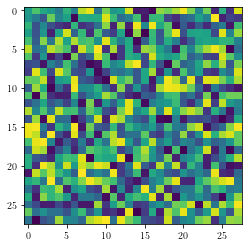

In [13]:
plt.imshow(res['rand_oodX'][0])